loss is [7.0511201e+03 9.1210164e-02 7.0602412e+03]
loss is [3.76558643e+03 1.06695704e-01 3.77625610e+03]
loss is [2.3200688e+03 2.2103296e-01 2.3421721e+03]
loss is [223.28917     1.0053943 323.8286   ]
loss is [107.38252      0.73260397 180.64291   ]
loss is [ 82.56275     0.5057413 133.13689  ]
loss is [45.770092    0.34811044 80.58113   ]
loss is [29.295717   0.2591004 55.205757 ]
loss is [15.105392    0.18575239 33.680634  ]
loss is [20.182259    0.15729566 35.911823  ]
loss is [ 7.0253882   0.08083858 15.109247  ]
loss is [58.027687    0.07292452 65.32014   ]
loss is [ 8.766942    0.06340748 15.10769   ]
loss is [ 6.2679954   0.05976729 12.244724  ]
loss is [24.372318   0.0630872 30.681038 ]
loss is [4.197085   0.04242307 8.439392  ]
loss is [ 7.887781    0.05727297 13.615078  ]
loss is [5.793548   0.03914748 9.708296  ]
loss is [ 9.466697    0.03012824 12.479521  ]
loss is [5.206231   0.01785168 6.991399  ]
loss is [4.4953127 0.023857  6.881013 ]
loss is [4.492652   0.01553018 

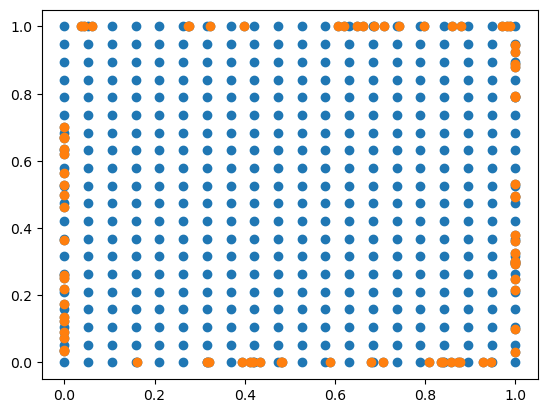

In [1]:
import sys
sys.path.append('../')

import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib

from user_funn.field import D2Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.geom import line_sample
import user_funn.plot

batch_num = 1
# STEP1 data generate
nx = 20
pde_epoch_size = nx * nx * batch_num
pde_batch_size = nx * nx 
field = D2Field([0,1],[0,1])
#pde_input = field.get_field_rand(pde_epoch_size)
pde_input = field.get_field_mesh([20,20])
pde_output = np.zeros([pde_epoch_size,1])


bc_batch_size = nx
bc_epoch_size = bc_batch_size * batch_num
bc_left_x = line_sample([0,0],[0,1], bc_epoch_size)
bc_up_x = line_sample([0,1],[1,1], bc_epoch_size)
bc_right_x = line_sample([1,1],[1,0], bc_epoch_size)
bc_down_x = line_sample([1,0],[0,0], bc_epoch_size)
bc_input = np.vstack([bc_left_x, bc_up_x, bc_right_x, bc_down_x])
bc_output = np.zeros([bc_input.shape[0],1])

pde_input = np.vstack([pde_input, bc_input])
pde_output = np.vstack([pde_output, bc_output])

user_funn.plot.scatter_2d_cloud_point_kind([pde_input,bc_input])
pde_batch_size = pde_input.shape[0] // batch_num
bc_batch_size = bc_epoch_size // batch_num


# STEP2 loss define
cloud_point_data = [[pde_input, pde_output],[bc_input, bc_output]]

loss_fn = torch.nn.MSELoss()

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)

    # 数据提取
    x = x_in[:,[0]]
    y = x_in[:,[1]]
    u = U[:,[0]]

    # p,u,v shape = (128*1)
    # 计算一阶导
    dudi = grad(u, x_in)[0]
    dudx = dudi[:,[0]]
    dudy = dudi[:,[1]]
    # 计算二阶导
    du2dxi = grad(dudx, x_in)[0]
    du2dx2 = du2dxi[:,[0]]
    du2dyi = grad(dudy, x_in)[0]
    du2dy2 = du2dyi[:,[1]]

    k0 = 2*torch.pi*2
    loss = -du2dx2 - du2dy2 - (k0 ** 2) * u \
         - (k0**2) * torch.sin(k0 * x) * torch.sin(k0 * y)
    loss_val = loss_fn(loss, y_real)
    return loss_val

def data_loss(model, data):
    # 数据提取
    x_in,y_real = data
    U = model(x_in)
    x = x_in[:,[0]]
    y = x_in[:,[1]]
    u = U[:,[0]]

    loss_val = loss_fn(u, y_real)
    return loss_val

solver = CloudPointSolver(
    [[pde_input, pde_output],[bc_input, bc_output]],
    [pde_loss,data_loss],
    loss_weight_list = [1,100],
    model = [2, 150, 150, 150, 1],
    optimizer = "adam",
    batchsize = [pde_batch_size,bc_batch_size])

for i in range(100000):
    solver.train_step()
    if i % 1000 == 0:
        solver.test_step(print_flag=True)

print('train over')



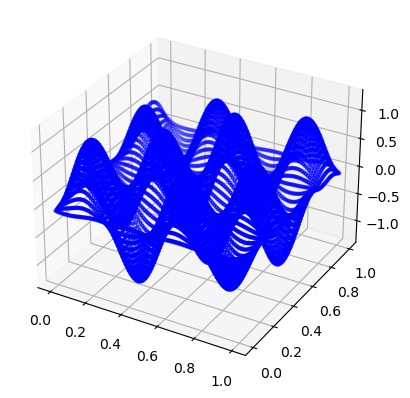

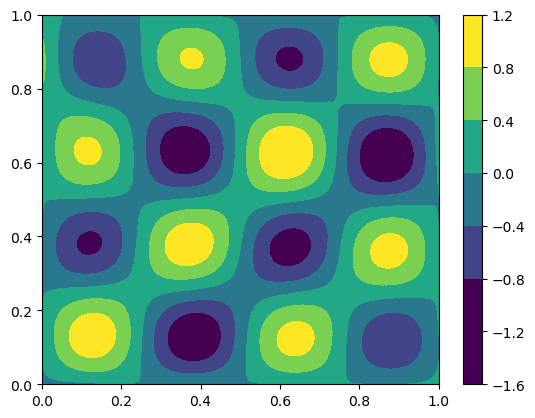

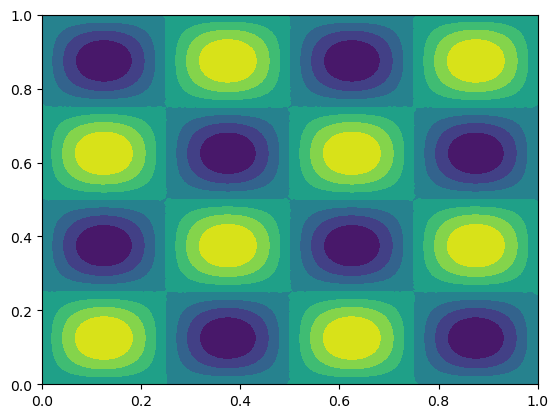

0.10519397605299459

In [2]:
pde_input = field.get_field_mesh([100,100])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_pde_output = solver.model_eval(pde_input)
ax.scatter(pde_input[:,0], pde_input[:,1], plot_pde_output[:,0],\
    c = 'b', marker='.')

norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

plt.figure()
cm1 = plt.tricontourf(pde_input[:,0].ravel().ravel(), pde_input[:,1].ravel(), \
    plot_pde_output[:,0].ravel(),norm = norm)
plt.colorbar(cm1)
plt.show()

def anal_solve(pde_input):
    k0 = 2 * np.pi * 2
    plot_x = pde_input[:,0]
    plot_y = pde_input[:,1]
    return np.sin(k0*plot_x)*np.sin(k0*plot_y)


plt.figure()
plt.tricontourf(pde_input[:,0].ravel().ravel(), pde_input[:,1].ravel(), \
    anal_solve(pde_input),norm = norm)
plt.show()
np.mean(np.abs(anal_solve(pde_input)-np.array(plot_pde_output[:,0].ravel())))
